In [52]:
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import CSVLogger
from keras.layers.convolutional import Conv1D
from keras.layers import Flatten
from keras.layers.convolutional import MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences





[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/polinab/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Import and explore data

In [2]:
yelp_labelled = pd.read_csv('yelp_labelled.txt', sep='\t', header=None)
yelp_labelled.columns = ['text', 'label']
yelp_labelled.head(5)

,text,label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


<AxesSubplot:xlabel='label', ylabel='Count'>

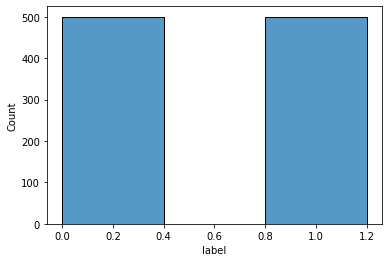

In [3]:
sns.histplot(data=yelp_labelled, x="label",bins=2,binwidth=0.4)


- 0 and 1 labels are equally distributed, so we do not need to resample the data
- 0 is a bad review, 1 is a good review
- small set of data, so we can use all of it

### Vectorize the word data
- a neural network model cannot interpret words, they need to be encoded into numbers
- external libraries exist that do this, like Word2Vec
- After playing around with the libraries I decided to make my own encoding to fully understand how the basics work
- getting rid of stop words made the model perform worse. Understandable since sequentially many of the stop words actually add information to the phrases! 

In [4]:
# separate into positive and negative posts
positive_posts = pd.Series.to_numpy(yelp_labelled[yelp_labelled.label == 1]['text'])
negative_posts = pd.Series.to_numpy(yelp_labelled[yelp_labelled.label == 0]['text'])

# keep an object with both sets for later use
posts = positive_posts + negative_posts

In [34]:
def unique_words(lines):
    '''
    returns dictionary of unique words in input
    assigns an integer key to each word
    does not include punctuation or stop words 
    stop words can be removed or included depending on the model
    '''
    unique_words = set()
    stop_words = set(stopwords.words('english'))

    for line in lines:
        for word in line:
#             if word not in stop_words:
#                 unique_words.add(word)
            unique_words.add(word)
    word_vals = set(i for i in range(len(unique_words)))
    word_keys = dict(zip(unique_words, word_vals))
    return word_keys

def word_to_vec(posts):
    '''
    encodes word input into integer arrays 
    stop words can be removed or included depending on the model
    '''
    stop_words = set(stopwords.words('english'))
    posts = [line.lower().translate(str.maketrans('', '', string.punctuation)).split(' ') for line in posts]
    word_dict = unique_words(posts)
    word_key_map = [[word_dict[word] for word in post] for post in posts]
#     word_key_map = [[word_dict[word] for word in post if word not in stop_words] for post in posts]
    return word_key_map

In [35]:
neg_encoded = word_to_vec(negative_posts)
pos_encoded = word_to_vec(positive_posts)
word_vecs = np.concatenate((neg_encoded, pos_encoded))
print(f'"{negative_posts[0]}" becomes {word_vecs[0]}')


"Crust is not good." becomes [864, 1301, 166, 1044]


In [44]:
# Padding the data samples to a maximum review length in words
longest_post = max([len(post) for post in word_to_vec(posts)])
padded_word_vecs = sequence.pad_sequences(word_vecs, maxlen=longest_post)


In [8]:
# re-create labels, concatenate with data, and set up test/train split
labels = np.concatenate((np.zeros(len(neg_encoded)), np.ones(len(pos_encoded))))
X_train, X_test, y_train, y_test = train_test_split(padded_word_vecs,labels,test_size=0.33)

print('X_train shape:', X_train.shape, y_train.shape)
print('X_test shape:', X_test.shape, y_test.shape)

X_train shape: (670, 46) (670,)
X_test shape: (330, 46) (330,)


### Word-wise LSTM Model
LSTM is an artificial RNN architecture.
reference: https://towardsdatascience.com/a-beginners-guide-on-sentiment-analysis-with-rnn-9e100627c02e

In [24]:
vocab_size = max([max(arr) for arr in word_to_vec(posts)])
embedding_size = 32
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, embedding_size, input_length=longest_post))
lstm_model.add(LSTM(embedding_size))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation='sigmoid'))
print(lstm_model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 46, 32)            77472     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 85,825
Trainable params: 85,825
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
lstm_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

batch_size = 64
num_epochs = 20
csv_logger = CSVLogger("lstm.csv", append=False)
lstm_model.fit(X_train, y_train, 
               epochs=num_epochs, 
               verbose=1,
               callbacks=[csv_logger],
               validation_data=(X_test,y_test)
              )


Epoch 1/20
21/21 [==============================] - 3s 48ms/step - loss: 0.6913 - accuracy: 0.5471 - val_loss: 0.6816 - val_accuracy: 0.7727
Epoch 2/20
21/21 [==============================] - 0s 18ms/step - loss: 0.6640 - accuracy: 0.8143 - val_loss: 0.5793 - val_accuracy: 0.7091
Epoch 3/20
21/21 [==============================] - 0s 19ms/step - loss: 0.5036 - accuracy: 0.8386 - val_loss: 0.4079 - val_accuracy: 0.7727
Epoch 4/20
21/21 [==============================] - 0s 18ms/step - loss: 0.3367 - accuracy: 0.9198 - val_loss: 0.2474 - val_accuracy: 0.9758
Epoch 5/20
21/21 [==============================] - 0s 18ms/step - loss: 0.1874 - accuracy: 0.9912 - val_loss: 0.1398 - val_accuracy: 0.9788
Epoch 6/20
21/21 [==============================] - 0s 18ms/step - loss: 0.1021 - accuracy: 0.9952 - val_loss: 0.1073 - val_accuracy: 0.9788
Epoch 7/20
21/21 [==============================] - 0s 18ms/step - loss: 0.0702 - accuracy: 0.9968 - val_loss: 0.0884 - val_accuracy: 0.9697
Epoch 8/20
21

In [26]:
scores = lstm_model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', scores[1])

Test accuracy: 0.9636363387107849


<AxesSubplot:xlabel='epoch'>

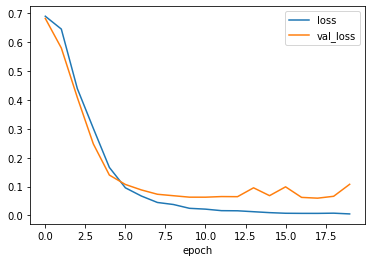

In [27]:
lstm_scores_df = pd.read_csv("lstm.csv")
lstm_scores_df.set_index('epoch', inplace=True)
# lstm_scores_df[['loss','val_loss']].plot()

lstm_scores_df[['loss','val_loss']].plot()


### Word-wise CNN Model
https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

In [13]:
embedding_size = 50
cnn_model = Sequential()
cnn_model.add(Embedding(vocab_size, embedding_size, input_length=longest_post))
cnn_model.add(Conv1D(embedding_size,kernel_size=8, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(10, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 46, 50)            121050    
_________________________________________________________________
conv1d (Conv1D)              (None, 39, 50)            20050     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 50)            0         
_________________________________________________________________
flatten (Flatten)            (None, 950)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                9510      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 150,621
Trainable params: 150,621
Non-trainable params: 0
________________________________________________

In [14]:
num_epochs = 20

csv_logger = CSVLogger("cnn.csv", append=False)

cnn_model.fit(X_train, y_train, epochs=num_epochs, verbose=1)

Epoch 1/20
21/21 [==============================] - 1s 5ms/step - loss: 0.6921 - accuracy: 0.5079
Epoch 2/20
21/21 [==============================] - 0s 4ms/step - loss: 0.6283 - accuracy: 0.7658
Epoch 3/20
21/21 [==============================] - 0s 5ms/step - loss: 0.3063 - accuracy: 0.9520
Epoch 4/20
21/21 [==============================] - 0s 4ms/step - loss: 0.1110 - accuracy: 0.9634
Epoch 5/20
21/21 [==============================] - 0s 5ms/step - loss: 0.0466 - accuracy: 0.9857
Epoch 6/20
21/21 [==============================] - 0s 5ms/step - loss: 0.0292 - accuracy: 0.9920
Epoch 7/20
21/21 [==============================] - 0s 4ms/step - loss: 0.0200 - accuracy: 0.9976
Epoch 8/20
21/21 [==============================] - 0s 5ms/step - loss: 0.0166 - accuracy: 0.9987
Epoch 9/20
21/21 [==============================] - 0s 4ms/step - loss: 0.0129 - accuracy: 0.9993
Epoch 10/20
21/21 [==============================] - 0s 6ms/step - loss: 0.0071 - accuracy: 0.9998
Epoch 11/20
21/21 [

In [15]:
scores = cnn_model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', scores[1])

Test accuracy: 0.9666666388511658


<AxesSubplot:xlabel='epoch'>

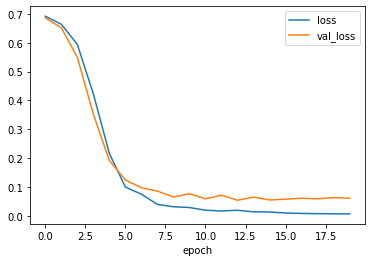

In [16]:
cnn_scores_df = pd.read_csv("cnn.csv")
cnn_scores_df.set_index('epoch', inplace=True)
cnn_scores_df[['loss','val_loss']].plot()

In [17]:
#todo: play around with different values for the two models above. 
# Add different layers
# show convergence of validation loss after number of epochs
# show difference using dictionaries from full set vs just train set

### Vectorize the character data

In [55]:
def char_tokenizer(lines):
    tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
    lines_low = [[l.lower() for l in lines]]
    tk.fit_on_texts(lines_low)

    alphabet = "abcdefghijklmnopqrstuvwxyz0123456789,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
    char_dict = {}
    for i, char in enumerate(alphabet):
        char_dict[char] = i + 1

    # Use char_dict to replace the tk.word_index
    tk.word_index = char_dict.copy()
    # Add 'UNK' to the vocabulary
    tk.word_index[tk.oov_token] = max(char_dict.values()) + 1
    return tk

In [49]:
def embed_weights(tk):
    vocab_size = len(tk.word_index)
    embedding_weights = []
    embedding_weights.append(np.zeros(vocab_size))

    for char,i in tk.word_index.items():
        onehot = np.zeros(vocab_size)
        onehot[i-1] = 1
        embedding_weights.append(onehot)

    return np.array(embedding_weights)

In [63]:
# transform reviews into character encodings:

posts = positive_posts + negative_posts
tk = char_tokenizer(posts)
vocab_size = len(tk.word_index)
pos_seqs = tk.texts_to_sequences(positive_posts)
neg_seqs = tk.texts_to_sequences(negative_posts)
print(f'{positive_posts[0]} becomes {pos_seqs[0]}')

Wow... Loved this place. becomes [23, 15, 23, 39, 39, 39, 69, 12, 15, 22, 5, 4, 69, 20, 8, 9, 19, 69, 16, 12, 1, 3, 5, 39]


In [60]:
longest_post = max([len(x) for x in np.append(neg_seqs, pos_seqs, axis=0)])
print(f'longest post is {longest_post} characters long')


longest post is 149 characters long


/Users/polinab/.virtualenvs/deep/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [ ]:
# pad data:

pos_seq_padded = pad_sequences(pos_seqs, maxlen=longest_post, padding='post')
neg_seq_padded = pad_sequences(neg_seqs, maxlen=longest_post, padding='post')

pos_data = np.array(pos_seq_padded, dtype='float32')
neg_data = np.array(neg_seq_padded, dtype='float32')


In [ ]:
padded_char_vecs = np.append(neg_data, pos_seqs, axis = 0)

labels = np.concatenate((np.zeros(len(neg_data)), np.ones(len(pos_data))))
X_train, X_test, y_train, y_test = train_test_split(padded_char_vecs, labels, test_size=0.33)

print('X_train shape:', X_train.shape, y_train.shape)
print('X_test shape:', X_test.shape, y_test.shape)

In [62]:
padded_char_vecs = np.append(neg_data, pos_seqs, axis = 0)

labels = np.concatenate((np.zeros(len(neg_data)), np.ones(len(pos_data))))
X_train, X_test, y_train, y_test = train_test_split(padded_char_vecs, labels, test_size=0.33)

print('X_train shape:', X_train.shape, y_train.shape)
print('X_test shape:', X_test.shape, y_test.shape)

NameError: name 'pad_sequences' is not defined

In [ ]:
padded_char_vecs = np.append(neg_data, pos_seqs, axis = 0)

labels = np.concatenate((np.zeros(len(neg_data)), np.ones(len(pos_data))))
X_train, X_test, y_train, y_test = train_test_split(padded_char_vecs, labels, test_size=0.33)

print('X_train shape:', X_train.shape, y_train.shape)
print('X_test shape:', X_test.shape, y_test.shape)